In [2]:
steps_for_building_models={
    1:"Data (prepare and load)",
    2:"Build model",
    3:"Fitting model to data(training)",
    4:"Making prediction and evaluating a model (inference)",
    5:"Saving and loading a model",
    6:"Putting all together"
}
steps_for_building_models

{1: 'Data (prepare and load)',
 2: 'Build model',
 3: 'Fitting model to data(training)',
 4: 'Making prediction and evaluating a model (inference)',
 5: 'Saving and loading a model',
 6: 'Putting all together'}

## Pytorch model building essentials

Pytorch Cheat sheet ---> https://pytorch.org/tutorials/beginner/ptcheat.html

* [torch.nn](https://pytorch.org/docs/stable/nn.html) ---> contains all the necessary building blocks for computational graphs (i.e neural networks).
* torch.nn.Parameter ---> what parameters our model must try and learn (often a Pytorch
layer from torch.nn will set these for us).
* torch.nn.Module ---> The base call for all Neural network modules, if subclasses we must overwrite the frward method.
* torch.optim ---> It contains all the pytorch optimizers that helps with gradient descent.
* def forward() ---> All nn.Module subclasses require you to overwrite this method, It defines what happens in the forward computation.
* torch.utils.data.Dataset ---> Represents a map between key(label) and sample(features) pairs of the data.
* torch.utils.data.DataLoader ---> Creates a Python iterable over a torch Dataset.


In [3]:
import torch
import torch.nn  #nn contains all the building blocks for neural networks
import matplotlib.pyplot as plt

#Check Pytorch version
torch.__version__

'2.4.1+cu121'

In [27]:
device='cuda' if torch.cuda.is_available() else "cpu"
print(f'Device:{device}')

Device:cuda


## Data preprocessing and Loading

* Get the data into a numerical representation
* Build a model to learn patterns in thatnumerical representation

In [5]:
# Linear regression Data to create a model
#Y=a+bX
weight=0.7  #a
bias=0.3    #b

start=0
end=1
step=0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias

X[:10],y[:10],len(X),len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

## Split the data in training, validation and test sets

In [6]:
#create a train/test split
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]

len(X_train),len(X_test),len(y_train),len(y_test)

(40, 10, 40, 10)

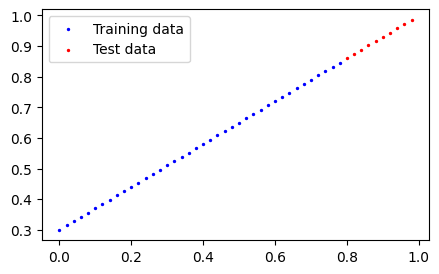

In [7]:
def plot_prediction(train_data=X_train,train_label=y_train,test_data=X_test,test_label=y_test,prediction=None):
  """Plot train and test data"""
  plt.figure(figsize=(5,3))
  plt.scatter(train_data,train_label,c='b',s=2,label="Training data")
  plt.scatter(test_data,test_label,c='r',s=2,label="Test data")
  if prediction is not None:
    plt.scatter(test_data,prediction,c='g',s=8,marker="*",label="Prediction")
  plt.legend()
  plt.show()

plot_prediction()

## Build Pytorch model

* We start with random values of weight and bias.
* Look at the training data and adjust values to better represent the  ideal (or close) values.

We do this using:
1. Gradient Descent
2. Backpropogation

In [8]:
#Creating a linear regression model class
from torch import nn
class LinearRegressionModel(nn.Module):  #<- almost everything in Pytorch inherits from nn.Module
  #Initialize the model parameters
  def __init__(self):
    super().__init__()
    self.weights=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    self.bias=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

  #Forward method to define the computation in the model
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.weights*x+self.bias


class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    #USe nn.Linear() for creating model parameters
    self.linear_layer=nn.Linear(in_features=1,out_features=1)
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


In [9]:
# Checking the contents of the model

#create a random seed
torch.manual_seed(42)

#Craete the instance of the model
model0=LinearRegressionModel()

model1=LinearRegressionModelV2()

#Check the parameters
list(model0.parameters())

#List the names parameters
print(model0.state_dict())
print(model1.state_dict())

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('linear_layer.weight', tensor([[-0.2191]])), ('linear_layer.bias', tensor([0.2018]))])


## Making prediction using `torch.inference_mode()`

In [10]:
with torch.inference_mode():
  y_preds=model0(X_test)
y_preds

#Older method which could be used
# with torch.no_grad():
#   y_preds=model0(X_test)



tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

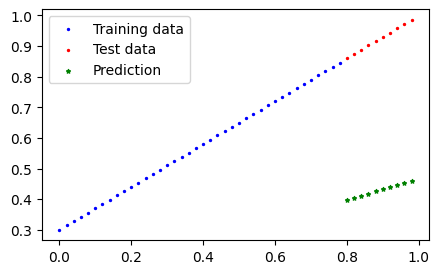

In [11]:
plot_prediction(prediction=y_preds)

## Train the model


Things we need to train:
* **Loss Function** A function to measure how wrong the models prediction are from the idela values
* **Optimizer** Takes into account the loss of the model and adjusts the models parameters to imporve the loss function

And specifically for Pytorch we need:
* A Training loop
* A Testing loop

In [12]:
#setup loss fuction
loss_fn=nn.L1Loss() #Mean absolute loss

#setup optimizer
optimizer=torch.optim.SGD(params=model0.parameters(),lr=0.01)

**Q:** Which loss function and optimizer to use?

**A:** This depends on the problem. For eg. for a regression problem, a loss function of `torch.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.But for classification problem we will likely use the loss function of `nn.BCELoss()`(binary cross entropy loss).



### Training and Testing loop

Steps:
0. Loop through the data.
1. Forward Pass (involves moving the data through the model's `forward()` functions)- make prediction in data.
2. Calculate the loss
3. Optimizer zero grad
4. Backward pass
5. Optimizer step

Learning rate scheduling?

In [13]:
model0.state_dict() #Before Training

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
torch.manual_seed(42)
epochs=175

#To track different values
epoch_count=[]
loss_values=[]
test_loss_values=[]

print("MODEL0")
#Loop through the data
for epoch in range(epochs):
  #Set the model to training mode
  model0.train()
  #Forward pass
  y_pred=model0(X_train)
  #Calculate loss
  loss=loss_fn(y_pred,y_train)
  #Optimizer
  optimizer.zero_grad()
  #Backward pass on loss w.r.t parameter
  loss.backward()
  #perporm gradient descent
  optimizer.step()



  ###Test Loop
  model0.eval() #Turns off different settings in the model not needed for evaluating/testing
  with torch.inference_mode(): #turns off gradient tracking, etc.
    #Forward pass
    test_pred=model0(X_test)
    #Calculate the loss
    test_loss=loss_fn(test_pred,y_test)
  if epoch%10==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epochs:{epoch} | Loss: {loss} | Test Loss: {test_loss}")

  #Print model state dict
  #print(model0.state_dict())

MODEL0
Epochs:0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
Epochs:10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
Epochs:20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
Epochs:30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
Epochs:40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
Epochs:50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
Epochs:60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
Epochs:70 | Loss: 0.03476089984178543 | Test Loss: 0.0805937647819519
Epochs:80 | Loss: 0.03132382780313492 | Test Loss: 0.07232122868299484
Epochs:90 | Loss: 0.02788739837706089 | Test Loss: 0.06473556160926819
Epochs:100 | Loss: 0.024458957836031914 | Test Loss: 0.05646304413676262
Epochs:110 | Loss: 0.021020207554101944 | Test Loss: 0.04819049686193466
Epochs:120 | Loss: 0.01758546568453312 | Test Loss: 0.04060482233762741
Epochs:130 | Loss: 0.014155393466353416 | Test Loss: 0.0323322787880

In [30]:
y_train.device

device(type='cuda', index=0)

In [36]:
###Model for Version2 i.e using torch.Linear()

model1.to(device)
next(model1.parameters()).device

#Put data on target device. Device agnistic code for data
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

#Loss function and optimizer
loss_fn1=nn.L1Loss()
optimizer1=torch.optim.SGD(params=model1.parameters(),lr=0.01)

#Training loop
torch.manual_seed(42)
epochs=200

print("Model1")
for epoch in range (epochs):
  model1.train()
  #Forward pass
  y_pred1=model1(X_train)
  loss1=loss_fn1(y_pred1,y_train)
  optimizer1.zero_grad()
  loss1.backward()
  optimizer1.step()

  model1.eval()
  with torch.inference_mode():
    test_pred1=model1(X_test)
    test_loss1=loss_fn1(test_pred1,y_test)

  if epoch%10==0:
    print(f"Epoch:{epoch}| Loss:{loss1} | Test Loss:{test_loss1}")

print(model1.state_dict())

Model1
Epoch:0| Loss:0.022613821551203728 | Test Loss:0.0524027943611145
Epoch:10| Loss:0.019185377284884453 | Test Loss:0.04413025453686714
Epoch:20| Loss:0.015746567398309708 | Test Loss:0.035857703536748886
Epoch:30| Loss:0.01231189351528883 | Test Loss:0.028272045776247978
Epoch:40| Loss:0.008881757967174053 | Test Loss:0.019999509677290916
Epoch:50| Loss:0.005442953202873468 | Test Loss:0.011726963333785534
Epoch:60| Loss:0.0020099603570997715 | Test Loss:0.004141300916671753
Epoch:70| Loss:0.008077466860413551 | Test Loss:0.006309491582214832
Epoch:80| Loss:0.008077466860413551 | Test Loss:0.006309491582214832
Epoch:90| Loss:0.008077466860413551 | Test Loss:0.006309491582214832
Epoch:100| Loss:0.008077466860413551 | Test Loss:0.006309491582214832
Epoch:110| Loss:0.008077466860413551 | Test Loss:0.006309491582214832
Epoch:120| Loss:0.008077466860413551 | Test Loss:0.006309491582214832
Epoch:130| Loss:0.008077466860413551 | Test Loss:0.006309491582214832
Epoch:140| Loss:0.008077466

In [16]:
model0.state_dict() #After Training

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

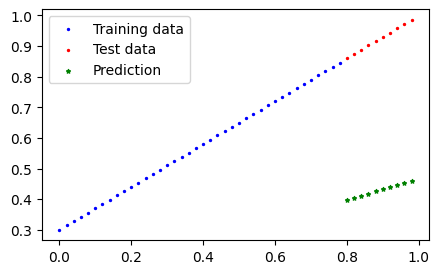

In [17]:
plot_prediction(prediction=y_preds) #Before training

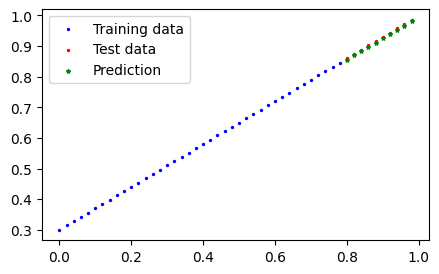

In [18]:
with torch.inference_mode():
  y_preds=model0(X_test)
plot_prediction(prediction=y_preds) #After training

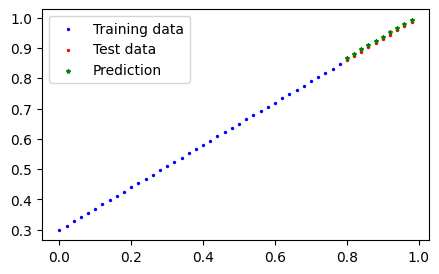

In [42]:
#For model using nn.Linear
model1.eval()
with torch.inference_mode():
  y_preds1=model1(X_test)
plot_prediction(prediction=y_preds1.cpu()) #After training

In [19]:
import numpy as np
loss_values=np.array(torch.tensor(loss_values).numpy())

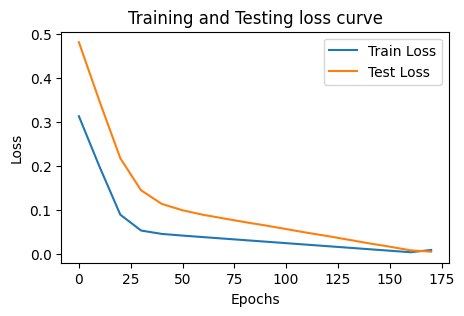

In [20]:
#Plot loss curve
plt.figure(figsize=(5,3))
plt.plot(epoch_count,loss_values,label="Train Loss")
plt.plot(epoch_count,test_loss_values,label="Test Loss")
plt.title("Training and Testing loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Saving a Model

Three methods to save and load models :
* `torch.save()`- allows to save Pytorch object in the python pickle format.
* `torch.load()`- allows to load a Pytorch saved object.
* `torch.nn.Module.load_state_dict()`- allows to load the model's saved state dictionay.

Docs: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [45]:
from pathlib import Path

#Create model directory
MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#Create model save path
MODEL_NAME0="01_LinearRegression.pth"
MODEL_NAME1="01_LinearRegressionV2.pth"

MODEL_SAVE_PATH0=MODEL_PATH/MODEL_NAME0
MODEL_SAVE_PATH1=MODEL_PATH/MODEL_NAME1

#SAVE the models save dictionary
print("Saving the model")
torch.save(obj=model0.state_dict(),f=MODEL_SAVE_PATH0)
torch.save(obj=model1.state_dict(),f=MODEL_SAVE_PATH1)

Saving the model


In [46]:
!ls models

01_LinearRegression.pth  01_LinearRegressionV2.pth


## Loading the model

Since we saved the model's `state_dict()` rather than the whole model, we will create a new instance of the model class and load the `state_dict()` into it.

In [23]:
#Initialize new instance of the model
model_load=LinearRegressionModel()

#Print teh state dict before loading
print(model_load.state_dict())

#Load the saved state dict of model0
model_load.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

#Print state dict after laoding
print(model_load.state_dict())

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])


<ipython-input-23-948a4631ede6>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_load.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


In [24]:
#Make predictions
model_load.eval()
with torch.inference_mode():
  model_load_pred=model_load(X_test)
model_load_pred

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [25]:
#Check if model0 is equal to model_load
y_preds==model_load_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])